In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Midterm Study Guide

So far in this class, we have worked with the following topics.

* Rootfinding
  * Midpoint Methods
  * Newton and Secant Methods
  * Convergence classes of iterative methods (q-linear and q-quadratic)
* Conditioning of problems
* Stability of algorithms
* Numerical Linear Algebra
  * Thinking abstractly about vectors
  * Inner products and norms
  * Projectors $P = I - v v^T$ where $\lVert v \rVert = 1$
  * Reflectors $F = I - 2 v v^T$ where $\lVert v \rVert = 1$
  * Gram-Schmidt algorithm for QR factorization
  * Householder algorithm for QR factorization
  * Leading order cost of algorithms (like big-$O$, but we quantify the leading coefficient)
  * Solution of linear equations and linear least squares problems
  
I recommend reviewing the class notebooks, in-class activities, and homeworks.  Below, I'll give some discussion of the sort of questions that I could ask.

## Rootfinding

All rootfinding methods attempt to find $x$ such that $f(x) = 0$, but they require different information about $f$ and/or where to look.
If we know $f'(x) < 0$, which methods can be used?  What if we also know that $f(a) > 0 > f(b)$?  Does any method guarantee that we find a unique solution?

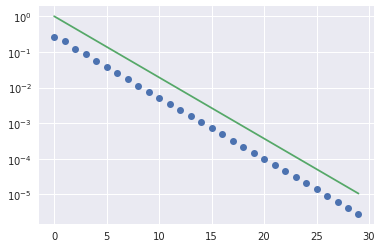

In [4]:
def iterate(f, x0, n):
    """Apply n iterations of x_{i+1} = f(x_i),
    return resulting history as an array.
    """
    hist = [x0]
    for i in range(n):
        hist.append(f(hist[i]))
    return np.array(hist)

def f1(x):
    return np.cos(x)

hist1 = iterate(f1, 1, 80)
x_star = hist1[-1] # Suppose the last estimate is best
plt.semilogy(np.abs(hist1[:30] - x_star), 'o');
plt.semilogy(np.sin(x_star)**np.arange(30));

In [6]:
np.sin(x_star)

0.6736120291832185

What convergence class is the above figure evidence of?

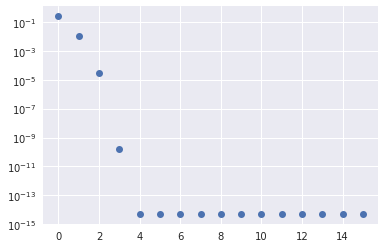

In [3]:
def f2(x):
    return x - (np.cos(x) - x) / (-np.sin(x) - 1)

hist2 = iterate(f2, 1, 15)
plt.semilogy(np.abs(hist2 - x_star), 'o');

What convergence class is the above plot evidence of?

What happens after the fourth iteration?

Can you sketch a function such that Newton exhibits a certain behavior, such as error decreasing while residual increases?

## Conditioning

You should be able to estimate (relative) condition numbers (a finite number or $\infty$) for differentiable functions such as $\sin x$ at a given value of $x$.  Recall that for differentiable functions, the relative condition number is
$$ \kappa = \lvert f'(x) \rvert \frac{\lvert x \rvert}{\lvert f(x) \rvert} . $$
You should be able to estimate condition number for a $2\times 2$ diagonal matrix, for example.

## Stability

You should be able to recognize unstable algorithms, such as in the activity where we computed $\exp(-20)$ by directly evaluating the Taylor series.

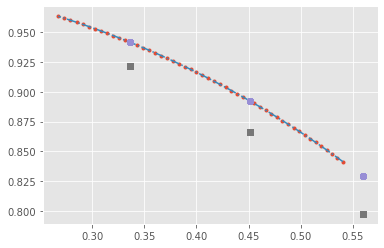

In [4]:
def g1(theta):
    return np.array([np.cos(theta), 
                     np.sin(theta)])

def g2(theta):
    return np.array([np.cos(theta),
                     np.cos(theta - np.pi/2)])

theta = np.linspace(1, 1.3)
plt.plot(*g1(theta), '.')
plt.plot(*g2(theta), '-.')
plt.plot(*g1(theta + np.pi*2e14), 'o')
plt.plot(*g2(theta + np.pi*2e14), 's');

Can you explain the plot above?  Is there evidence that one of these functions (`g1` or `g2`) is stable or backward stable?

## Numerical Linear Algebra

If $u$ and $v$ are vectors and I propose a function $h(u, v)$, can you determine whether it is an inner product?

There are two Moodle quizes about projections and matrix transformations.  If I ask a similar question, can you understand the terminology and show whether a property is true?

Is an orthogonal projector an orthogonal matrix?

If $Q$ has orthonormal columns, is $Q^T Q = Q Q^T$?  What if $Q$ is square?

In [5]:
def factor(A):
    A = A.copy()
    n = len(A)
    for i in range(n):
        ai = 1/A[i, i]
        A[i+1:, i] *= ai
        A[i+1:, i+1:] -= np.outer(A[i+1:, i], A[i, i+1:])
    return np.tril(A, -1) + np.eye(n), np.triu(A)

A = np.random.randn(4, 4)
L, U = factor(A)
np.linalg.norm(L @ U - A)

3.3422138886441676e-16

Which line in the above function is most expensive?

How much does it cost on the first iteration?

Can you write a sum of the cost over all loop iterations?

Can you write a $2\times 2$ matrix such that the above code fails?

Given a collection of vectors, how can you use QR factorization to build an orthogonal basis that spans the same space and where all but one vector has mean zero?

Given a matrix $A$, can you devise an elementary reflector $F = I - 2 v v^T$ such that the first column of the product $F A$ is a constant vector (all entries the same)?

### Sample question: QR

Solving a linear system using QR factorization requires solving $R x = y$ (where $R$ is upper triangular).
The "back substitution" algorithm starts with the last row (a scalar equation) and works up, solving for one additional entry in $x$ at a time.
The algorithm can be implemented in Python as
```python
  def R_solve(R, b):
      # Solve Rx = b using back substitution.
      x = b.copy()
      n = len(b)
      for i in reversed(range(n)): # from n-1 down to 0
          x[i] -= R[i,i+1:] @ x[i+1:] # dot product of length n-i-1
          x[i] /= R[i,i]
      return x
```
1. Count the number of flops performed by this algorithm and report the dominant term as a function of $n$ when $n$ is large.
      (This is like big-$O$ notation, but we keep track of multiplicative constants.  Count all elementary operations together.)
2. QR factorization of an $m\times n$ matrix using Gram-Schmidt requires $2 m n^2$ operations.  Multiplying $Q^T$ with a vector requires $2 m n$ operations.
To solve a linear (or least squares) problem $A x = b$ using QR, we compute $y = Q^T b$ and then solve $R x = y$.
Of course we can reuse the QR factorization for many right hand sides $b$.
How many right hand sides $k$ must we solve before the cost of solving all $k$ right hand sides equals the cost of QR factorization?

### Sample question: Newton
1. Sketch a figure of a strictly monotonic, differentiable function $f(x)$ with one root $x_* = 0$ and an initial guess $x_0$ for which one step of Newton's method (without line search) computes an $x_1$ with larger error and larger residual.  In other words,
$$ \lvert x_1 - x_* \rvert > \lvert x_0 - x_* \rvert \quad \text{and} \quad \lvert f(x_1)\rvert > \lvert f(x_0) \rvert .$$
    Mark the points $(x_0, f(x_0))$ and $(x_1, f(x_1))$ on the graph.
2. Same question, but choose the function and initial guess so that the error increases while the residual decreases:
    $$ \lvert x_1 - x_* \rvert > \lvert x_0 - x_* \rvert \quad \text{and} \quad \lvert f(x_1)\rvert < \lvert f(x_0) \rvert .$$
3. Same question, but choose the function and initial guess so that the error decreases while the residual increases:
    $$ \lvert x_1 - x_* \rvert < \lvert x_0 - x_* \rvert \quad \text{and} \quad \lvert f(x_1)\rvert > \lvert f(x_0) \rvert .$$

### Sample question: Convergence

We learned that a fixed point iteration $x_{i+1} = g(x_i)$ converges with rate $\lvert g'(x) \rvert$ for $x$ near a fixed point $x_*$.
1. Consider $g(x) = \cos x$ and estimate the q-linear convergence factor $\rho$ such that
      $$ \lim_{i \to \infty} \frac{\lvert x_{i+1} \rvert}{\lvert x_i \rvert} = \rho . $$
2. Write a function $h(x)$ such that $x_{i+1} = h(x_i)$ converges to the same $x_*$ at a faster rate (smaller $\rho$).

### Sample question: Linear algebra
An $m \times n$ matrix $A$, $m > n$, is said to have a pseudoinverse $G$ if the following conditions hold
    \begin{align}
      AGA &= A \\
      GAG &= G \\
      (AG)^T &= AG \\
      (GA)^T &= GA
    \end{align}

1. What is the shape of the matrix $G$?
2. If $A$ is full rank, we can compute its $QR$ factorization.  Which of the above conditions hold for $G = R^{-1} Q^T$?
3. Let $y = G b$.  Show that the residual $A y - b$ is orthogonal to the range of $Q$.  (Hint: Every point in the range of $Q$ can be represented as $Q x$ for some $x$. Since the range of $Q$ is equal to the range of $A$, this also proves that $x = y$ minimizes $\lVert A x - b \rVert$.)

### Sample question: Conditioning
The condition number of a function or algorithm is the relative sensitivity of the output to the input:
    $$\kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|}$$
where $\delta f = f(x + \delta x)$.  If $f$ is differentiable, we can take the limit of $\delta x \to 0$ and write as
    $$\kappa = |f'(x)| \frac{|x|}{|f|}.$$
Estimate the condition number of the following functions:
1. `log(x)` for $x = 1 + 10^{-10}$
2. `log1p(x)` for $x = 10^{-10}$.  (`log1p` is a function that accurately evaluates $\log(1+x)$, i.e., without computing $1+x$.)
3. `expm1(x)` for $x = 10^{-10}$.  (`expm1` is a function that accurately evaluates $e^x - 1$.)
4. `exp(x)` for $x = 10^{-10}$.
